In [1]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

In [2]:
import sys

sys.path.insert(0, "/home1/smaruj/akita_utils/")

from akita_utils import *

2022-06-29 18:47:17.883688: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-29 18:47:17.888782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64:/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib:/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-06-29 18:47:17.

In [3]:
import pysam
import h5py

In [4]:
genome_open = pysam.Fastafile("/project/fudenber_735/genomes/mm10/mm10.fa")

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print("Tensorflow: ", tf.__version__)

from basenji import dataset, seqnn, dna_io, stream

Tensorflow:  2.9.1


In [6]:
# NOTE
# head_i = 0 #human
# head_i = 1 #mouse
#

head_i = 1 #mouse
# head_i = 0
model_num = 1 #which fold to use


#base_dir = '/project/fudenber_735/backup/DNN_HiC/human-mouse_5-16-21/'
#model_dir = base_dir+"/f"+str(model_num)+"_c0/train/"

base_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models/"
model_dir = base_dir + "/f" + str(model_num) + "c0/train/"
model_file  = model_dir + "/model" + str(head_i) + "_best.h5"


# model_dir = '/home1/fudenber/repositories/basenji/manuscripts/akita/'
# model_file = model_dir+'/model_best.h5'

params_file = model_dir + "/params.json"
# params_file -> json (dict) with model's parameters
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params["model"]
    params_train = params["train"]
seq_length = params_model["seq_length"]
params_model["verbose"] = False

seqnn_model = seqnn.SeqNN(params_model)
print("built")

seqnn_model.restore(model_file, head_i=head_i)    # model with the mouse head
print("restored")


2022-06-29 18:48:04.121461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64:/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib:/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-06-29 18:48:04.121490: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-29 18:48:04.121510: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (endeavour1.usc.edu): /proc/driver/nvidia/version does 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1310720, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1310720, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1310720, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

In [7]:
hic_diags = params_model["diagonal_offset"]
try:
    target_crop = params_model["trunk"][-2]["cropping"]
except:
    target_crop = params_model["target_crop"]

print("hic_diags: ", hic_diags) 
print("target_crop: ", target_crop)
print("seq_length: ", seq_length)

target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags) * ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size, 2)    # Return the indices for the upper-triangle of an (n, m) array, here k=2 (diagonal offset)
# target_map_size, target_length_cropped, triu_tup[0].shape

print("target_length_cropped: ", target_length_cropped)
print("target_map_size: ", target_map_size)
print("shape of triu_tup[0]: ", triu_tup[0].shape)

hic_diags:  2
target_crop:  64
seq_length:  1310720
target_length_cropped:  130305
target_map_size:  512
shape of triu_tup[0]:  (130305,)


In [8]:
chrom = ["chr7", "chr18"]
start = [65000000, 64459666]
chunk = 1310720

In [9]:
for i in range(len(chrom)):
    if i == 0:
        mouse_frag = dna_io.dna_1hot(genome_open.fetch(chrom[i], start[i], start[i] + chunk).upper())
    else:
        new_frag =  dna_io.dna_1hot(genome_open.fetch(chrom[i], start[i], start[i] + chunk).upper())
        mouse_frag = np.stack((mouse_frag, new_frag), axis=0)

In [10]:
mouse_frag, mouse_frag.shape

(array([[[False, False, False,  True],
         [False, False,  True, False],
         [False, False, False,  True],
         ...,
         [False, False, False,  True],
         [False, False, False,  True],
         [False,  True, False, False]],
 
        [[False, False, False,  True],
         [False, False, False,  True],
         [ True, False, False, False],
         ...,
         [ True, False, False, False],
         [False, False, False,  True],
         [False,  True, False, False]]]),
 (2, 1310720, 4))

In [11]:
pred = seqnn_model.predict(mouse_frag)
                           # , batch_size=10)   # so 20/10 = 2 batches

1/1 [==============================] - 13s 13s/step


In [12]:
targets = ["mESC", "mESC", "cortical neuron", "neocortex cortical neuron", "neural progenitor cell", "neocortex neural progenitor cell"]
# targets = ["HFF", "H1hESC", "GM12878", "IMR90", "HCT116"]

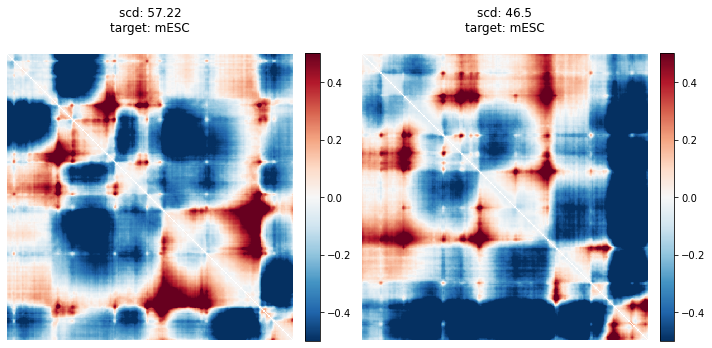

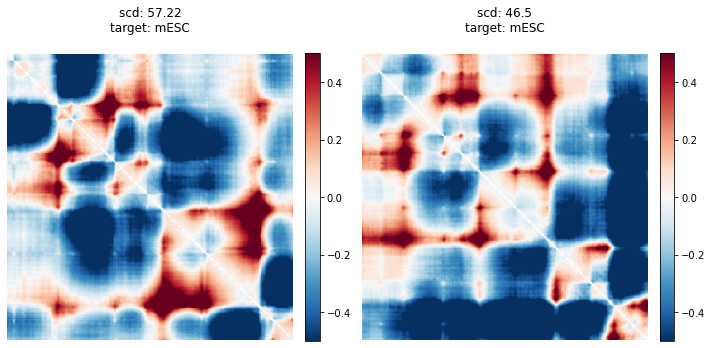

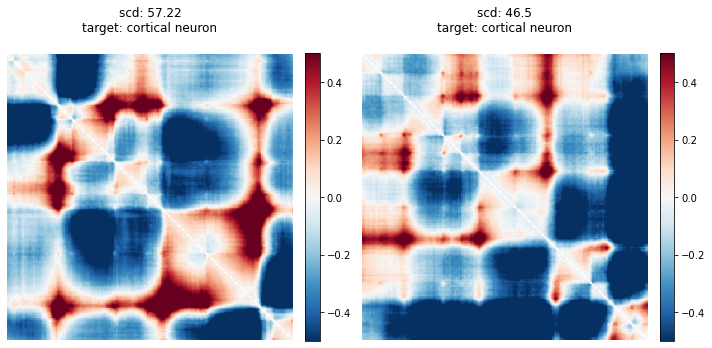

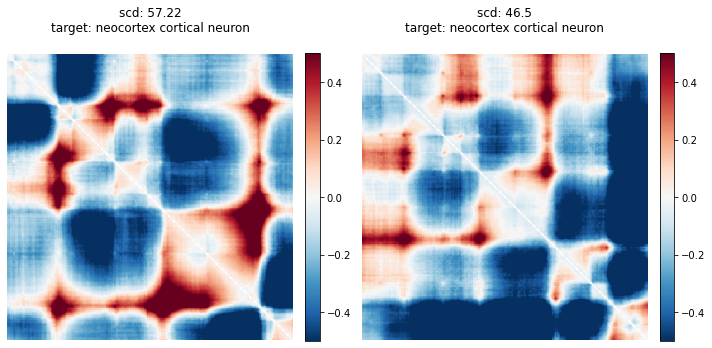

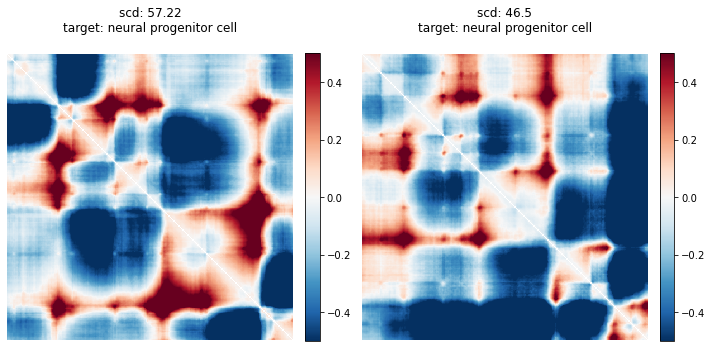

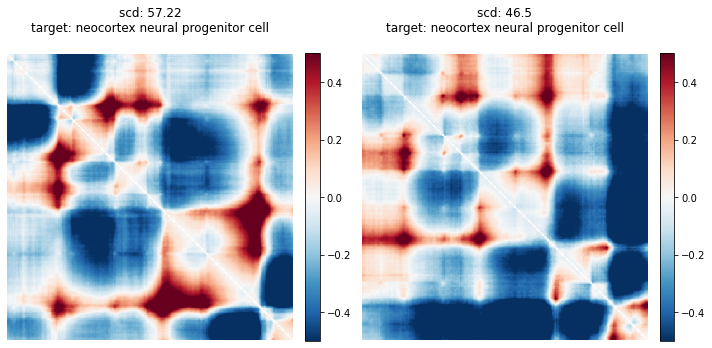

In [13]:

for j in range(pred.shape[-1]):
    plt.figure(figsize=(pred.shape[0]*5,pred.shape[-1]*5))
    target_ind = j
    vlim = .5
    bin_mid = target_map_size//2
    window = 50

    for i in range(len(pred)):
        insert_pred = pred[i]
        # print(i, np.sqrt( (insert_pred**2).sum(axis=0)))

        plt.subplot(6, 2, i+1)
        plt.axis("off")
        im = plt.matshow(
                from_upper_triu(  
                insert_pred[:,target_ind], target_map_size, hic_diags),
                vmin=-1*vlim, vmax=vlim, fignum=False, cmap="RdBu_r")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title("scd: " + str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean()) + "\n"
                 f"target: {targets[j]}")
            #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
    plt.tight_layout()
    plt.show()